<a href="https://colab.research.google.com/github/guilhsantos/RFV_Analysis_Clustering/blob/main/RFV_Analysis_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando as bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

Carregando Base de Dados

In [ ]:
from google.colab import files
upload = files.upload()

Saving data.csv to data.csv


# Etapa 01 - Carregamento e análise exploratória dos dados

In [ ]:
df = pd.read_csv("data.csv", encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Verificação dos Tipos dos Dados

Identificar o tipo de dado de cada coluna é essencial para entender como tratar cada variável. Por exemplo, variáveis numéricas podem precisar de normalização, enquanto variáveis categóricas precisam ser codificadas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Descrição Estatística dos Dados

O resumo estatístico vai me ajudar a ver a média, desvio padrão, valores máximos e mínimos, e pode revelar a presença de valores atípicos ou erros nos dados.

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Visualização das distribuições das variáveis mais relevantes
Visualizar as distribuições vai me ajudar a entender como as variáveis estão distribuídas. Podemos identificar padrões, assim como possíveis outliers.

Analisando a distribuição de Quantity

In [ ]:
fig = px.histogram(df, x='Quantity', nbins=50, title="Distribuição de Quantity")
fig.show()

Analisando a distribuição de UnitPrice

In [ ]:
fig = px.histogram(df, x='UnitPrice', nbins=50, title="Distribuição de UnitPrice")
fig.show()

Verificação de Dados Nulos

Detectamos valores ausentes e duplicados para garantir que os dados sejam limpos.

In [ ]:
null_counts = df.isnull().sum()
print("Contagem de dados nulos em cada coluna:")
print(null_counts[null_counts > 0])

Contagem de dados nulos em cada coluna:
Description      1454
CustomerID     135080
dtype: int64


Verificação de Dados Duplicados

In [ ]:
duplicate_counts = df.duplicated().sum()
print(f"Número de registros duplicados: {duplicate_counts}")

Número de registros duplicados: 5268


Verificação de Outliers em UnitPrice

Outliers podem distorcer a análise, principalmente quando se trabalha com técnicas de clusterização. O boxplot é uma maneira rápida de visualizar se há valores extremos.

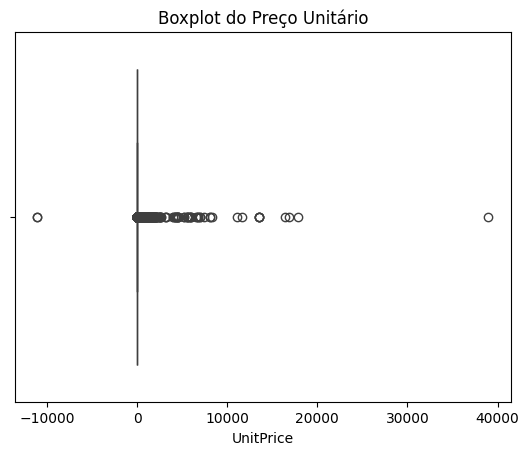

In [ ]:
sns.boxplot(x=df['UnitPrice'])
plt.title('Boxplot do Preço Unitário')
plt.show()

# Etapa 02 - Pré-processamento dos dados

## Nessa etapa será feita a normalização dos dados e removeção dos ruídos como duplicados e outliers para melhorar a performance

Criando uma nova coluna com o total gasto (Quantity * UnitPrice)

Essa nova variável será útil, pois representa o valor total gasto em cada compra, que é relevante para a análise de clusters.

In [ ]:
df['TotalSpent'] = df['Quantity'] * df['UnitPrice']

Seleção das variáveis mais relevantes para o modelo

O StandardScaler transforma os dados para que cada variável tenha média zero e desvio padrão igual a 1. Isso ajuda a evitar que variáveis com maiores escalas dominem o modelo.

In [ ]:
features = ['Quantity', 'UnitPrice', 'TotalSpent']
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

Removeção de dados nulos e duplicados e valores zero

A remoção de registros duplicados, nulos e unitprice zerados vai servir para evitar distorções nos resultados dos modelos.

In [ ]:
# Etapa de pré-processamento: Remover registros com UnitPrice igual a zero
filtered_data = filtered_data[filtered_data['UnitPrice'] > 0]

# Verificar se há valores nulos ou negativos em outras colunas que também devem ser removidos
filtered_data = filtered_data[filtered_data['Quantity'] > 0]  # Remover se Quantity for menor ou igual a zero
filtered_data = filtered_data[filtered_data['TotalSpent'] > 0]  # Remover se TotalSpent for menor ou igual a zero

# Verificar se há valores nulos em outras colunas
filtered_data = filtered_data.dropna()

# Verificação de dados nulos após o filtro
print(filtered_data.isnull().sum())


InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
TotalSpent      0
FinalCluster    0
dtype: int64


Removeção de outliers usando IQR

O IQR é uma forma eficaz de identificar e remover outliers, que poderiam distorcer a análise de clusters.

In [ ]:
q1 = filtered_data['TotalSpent'].quantile(0.25)
q3 = filtered_data['TotalSpent'].quantile(0.75)
iqr = q3 - q1
filtered_data = filtered_data[(filtered_data['TotalSpent'] >= (q1 - 1.5 * iqr)) & (filtered_data['TotalSpent'] <= (q3 + 1.5 * iqr))]


# Etapa 03 - Selecione um Algoritmo de Clusterização

## KMeans foi escolhido por ser eficiente e fácil de interpretar.

Usamos o Silhouette Score para escolher o número de clusters ideal. O Silhouette Score mede a qualidade da clusterização: quanto mais próximo de 1, melhor a separação dos clusters.

O Silhouette Score ajuda a identificar o número de clusters que oferece a melhor separação entre as observações. Testamos um intervalo de 2 a 20 clusters para garantir que encontramos o número ideal.

Dimensionalidade reduzida com PCA para visualização

In [ ]:
sample_data = df_scaled.sample(frac=0.1, random_state=0)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(sample_data)


Calculando o Silhouette Score para diferentes números de clusters

In [ ]:
silhouette_scores = []
for i in range(2, 21):  # Testando de 2 a 20 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduced_data)
    silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))


Visualizando o resultado do Silhouette Score

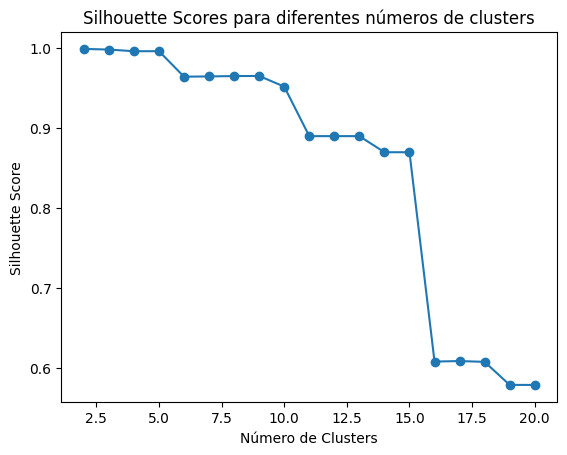

In [ ]:
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhouette Scores para diferentes números de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()


Melhor número de clusters

In [ ]:
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Número ótimo de clusters: {optimal_clusters}")


Número ótimo de clusters: 2


Aplicar o KMeans com o melhor número de clusters

O KMeans é um algoritmo eficiente e fácil de interpretar. Com o número ideal de clusters, ele irá agrupar os dados de forma que os dados dentro de cada cluster sejam mais semelhantes entre si do que com os dados de outros clusters.

In [ ]:
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
final_kmeans.fit(df_scaled.loc[filtered_data.index])
filtered_data['FinalCluster'] = final_kmeans.labels_

# Etapa 04 - Analise os Clusters Obtidos

Análise dos clusters

Os dados vão ser agrupados por cluster e calculamos a média das variáveis para entender as diferenças entre os clusters.

Agrupar os dados por cluster ajuda a entender as características médias de cada grupo e a tomar decisões estratégicas para o e-commerce.

In [ ]:
cluster_analysis = filtered_data.groupby('FinalCluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'TotalSpent': 'mean'
}).reset_index()

Visualização dos resultados

A visualização permite comparar rapidamente como cada cluster se comporta em termos de gasto total, ajudando na interpretação dos dados.


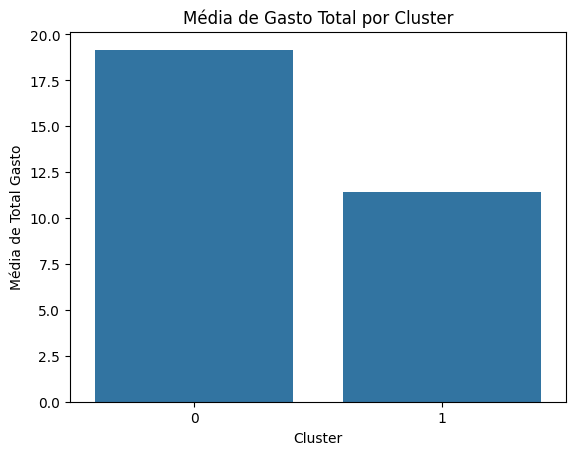

In [ ]:
sns.barplot(x='FinalCluster', y='TotalSpent', data=cluster_analysis)
plt.title('Média de Gasto Total por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Média de Total Gasto')
plt.show()

Análise detalhada e recomendações

A análise de cada cluster permite formular ações de marketing específicas, como oferecer descontos para clientes de baixo valor ou fidelizar clientes de alto valor.

In [ ]:
for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    cluster_data = filtered_data[filtered_data['FinalCluster'] == i]
    print(cluster_data.describe())
    print("\nProposta de ação:")
    if cluster_analysis.loc[i, 'TotalSpent'] > cluster_analysis['TotalSpent'].mean():
        print("Clientes de alto valor. Estratégia: Oferecer programas de fidelidade e descontos exclusivos.")
    else:
        print("Clientes de baixo valor. Estratégia: Oferecer promoções direcionadas e aumentar a comunicação.")
    print("\n")


Cluster 0:
          Quantity    UnitPrice    CustomerID   TotalSpent  FinalCluster
count  7444.000000  7444.000000   7444.000000  7444.000000        7444.0
mean     50.770688     0.419039  15129.063810    19.166879           0.0
std      27.256613     0.202580   1715.947542     7.804318           0.0
min      28.000000     0.040000  12347.000000     1.800000           0.0
25%      36.000000     0.290000  13712.000000    13.920000           0.0
50%      48.000000     0.390000  14911.000000    18.720000           0.0
75%      48.000000     0.420000  16701.000000    25.920000           0.0
max     900.000000     1.250000  18287.000000    36.480000           0.0

Proposta de ação:
Clientes de alto valor. Estratégia: Oferecer programas de fidelidade e descontos exclusivos.


Cluster 1:
            Quantity      UnitPrice     CustomerID     TotalSpent  \
count  347586.000000  347586.000000  347586.000000  347586.000000   
mean        6.711795       2.767042   15323.912646      11.433851   


# Conclusão

### Cluster 0 (Clientes de alto valor)

Tamanho do cluster: 7.444 registros (relativamente pequeno em relação ao total de registros)

Quantidade média (Quantity): 50,77 unidades. Isso sugere que os clientes desse grupo fazem compras em maior volume.

Preço médio unitário (UnitPrice): 0,42, indicando que os produtos comprados por esses clientes têm um preço unitário relativamente baixo.

Total gasto médio (TotalSpent): 19,17. Embora o preço unitário seja baixo, a quantidade comprada é alta, resultando em um total médio de gasto razoável.

Características principais:

Clientes com compras grandes (quantidade) e um total gasto significativo. Mesmo que o preço por unidade não seja muito alto, o volume de compras compensa, tornando esses clientes valiosos.

Proposta de ação: Como eles têm um gasto médio elevado, é interessante oferecer programas de fidelidade e descontos exclusivos para mantê-los como clientes frequentes e de alto valor para o negócio.

### Cluster 1 (Clientes de baixo valor)

Tamanho do cluster: 347.586 registros (grande parte dos dados)

Quantidade média (Quantity): 6,71 unidades. Esses clientes compram em menor quantidade, o que pode indicar que eles fazem compras menores, mais esporádicas ou de produtos mais baratos.

Preço médio unitário (UnitPrice): 2,77. O preço médio unitário é mais alto do que o do Cluster 0, o que sugere que esses clientes compram produtos mais caros, mas em menor quantidade.

Total gasto médio (TotalSpent): 11,43. Embora o preço por unidade seja mais alto, a quantidade comprada é menor, resultando em um total de gasto inferior ao Cluster 0.

Características principais:

Clientes com menor volume de compras e, portanto, com um gasto total mais baixo. Apesar de comprarem produtos mais caros, a frequência e quantidade de compras são menores, tornando-os menos valiosos em termos de receita.
Proposta de ação: Para incentivar esses clientes a gastar mais, você pode criar promoções direcionadas e aumentar a comunicação com eles, talvez oferecendo descontos ou benefícios que estimulem compras mais frequentes ou de maior volume.

## Conclusões gerais:

Cluster 0 (Clientes de alto valor) são aqueles que compram mais unidades, gastam mais no total e, por isso, merecem um tratamento especial com programas de fidelidade e ofertas exclusivas. Eles são importantes para garantir a receita recorrente e aumentar a lealdade ao negócio.

Cluster 1 (Clientes de baixo valor) têm um comportamento de compra diferente, fazendo compras menores ou em menor frequência, mas com preços unitários mais altos. Aqui, o objetivo é aumentar o engajamento e as compras desses clientes, com promoções personalizadas ou estratégias de marketing que incentivem a compra em maior volume.
